# Optical Digit Recognition with Parametric Lines

We model the prior on each digit as a collection of parametric lines
which can be traversed by a parameter $t \in [0, 1]$.

We model the data generating process as follows:
1. Choose a number from (0, 3).
2. For each number, sample the set of lines corresponding to the number.
3. Sample from a normal distribution centered at the point with standard deviation 0.05.

All digits will be in the range [0, 1] on both x and y axes.

In [1]:
using Gen
using Plots
using Printf
using LinearAlgebra

### Define Digit Sampling

In [2]:
mutable struct Digit
    xs::Vector{Float64}
    ys::Vector{Float64}
    lengths::Vector{Float64}   # Will be half as long as xs and ys
end

"Add a segment defined by two points to a digit"
function add_segment!(digit::Digit, p1::Vector{Float64}, p2::Vector{Float64})
    digit.xs = vcat(digit.xs, p1[1], p2[1])
    digit.ys = vcat(digit.ys, p1[2], p2[2])
    digit.lengths = vcat(digit.lengths, norm(p2 - p1))
end

"""
Sample a point along the digit.
t is a float between 0 and 1.
"""
function sample_digit_t(digit::Digit, t::Float64)::Vector{Float64}
    total_length::Float64 = sum(digit.lengths)
    t_length::Float64 = t * total_length
    n_segments = size(digit.lengths)[1]

    for i in 1:n_segments
        if t_length <= digit.lengths[i]
            t_segment = t_length / digit.lengths[i]
            return [digit.xs[2*i-1] + t_segment * (digit.xs[2*i] - digit.xs[2*i-1]),
                    digit.ys[2*i-1] + t_segment * (digit.ys[2*i] - digit.ys[2*i-1])]
        else
            t_length -= digit.lengths[i]
        end
    end
    throw("t out of bounds")
end

sample_digit_t

In [3]:
function get_digit(number::Int64)::Digit
    if number == 0
        xs = [0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
        ys = [0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0]
        lengths = [1.0, 1.0, 1.0, 1.0]
        digit = Digit(xs, ys, lengths)
    elseif number == 1
        digit = Digit([1.0, 1.0], [0.0, 1.0], [1.0])
    elseif number == 2
        segments = [[1.0, 0.0], [0.0, 0.0],
                    [0.0, 0.0], [0.0, 0.5],
                    [0.0, 0.5], [1.0, 0.5],
                    [1.0, 0.5], [1.0, 1.0],
                    [1.0, 1.0], [0.0, 1.0]]
        xs = map(x -> x[1], segments)
        ys = map(x -> x[2], segments)
        lengths = [1.0, 0.5, 1.0, 0.5, 1.0]
        digit = Digit(xs, ys, lengths)
    elseif number == 3
        segments = [[0.0, 0.0], [1.0, 0.0],
                    [1.0, 0.0], [1.0, 1.0],
                    [0.0, 0.5], [1.0, 0.5],
                    [0.0, 1.0], [1.0, 1.0]]
        xs = map(x -> x[1], segments)
        ys = map(x -> x[2], segments)
        lengths = [1.0, 1.0, 1.0, 1.0]
        digit = Digit(xs, ys, lengths)
    elseif number == 4
        segments = [[1.0, 0.0], [1.0, 1.0],
                    [0.0, 0.5], [1.0, 0.5],
                    [0.0, 0.5], [0.0, 1.0]]
        xs = map(x -> x[1], segments)
        ys = map(x -> x[2], segments)
        lengths = [1.0, 1.0, 0.5]
        digit = Digit(xs, ys, lengths)
    elseif number == 5
        segments = [[0.0, 0.0], [1.0, 0.0],
                    [1.0, 0.0], [1.0, 0.5],
                    [0.0, 0.5], [1.0, 0.5],
                    [0.0, 0.5], [0.0, 1.0],
                    [0.0, 1.0], [1.0, 1.0]]
        xs = map(x -> x[1], segments)
        ys = map(x -> x[2], segments)
        lengths = [1.0, 0.5, 1.0, 0.5, 1.0]
        digit = Digit(xs, ys, lengths)
    # elseif number == 6
    #     segments = [[0.0, 0.0], [0.0, 1.0],
    #                 [0.0, 0.0], [1.0, 0.0],
    #                 [1.0, 0.0], [1.0, 0.5],
    #                 [1.0, 0.5], [0.0, 0.5],
    #                 [0.0, 1.0], [1.0, 1.0]]
    #     xs = map(x -> x[1], segments)
    #     ys = map(x -> x[2], segments)
    #     lengths = [1.0, 1.0, 0.5, 1.0, 1.0]
    #     digit = Digit(xs, ys, lengths)
    else
        throw("Digit not supported")
    end
    return digit
end

@gen function sample_digit(digit::Digit, n::Int64)
    obs_xs = []
    obs_ys = []
    noise = 0.05
    for i in 1:n
        t = {(:t, i)} ~ uniform(0.0, 1.0)
        # t = uniform(0.0, 1.0)
        p_pure = sample_digit_t(digit, t)
        p_x = {(:p_x, i)} ~ normal(p_pure[1], noise)
        p_y = {(:p_y, i)} ~ normal(p_pure[2], noise)

        push!(obs_xs, p_x)
        push!(obs_ys, p_y)
    end
    return obs_xs, obs_ys
end

"Generate observations from a sampled number"
@gen function number_model()
    number = ({:number}) ~ uniform_discrete(0, 3)

    obs_xs, obs_ys = @trace(sample_digit(get_digit(number), 100))

    return obs_xs, obs_ys
end

number_model

### Plot example digit

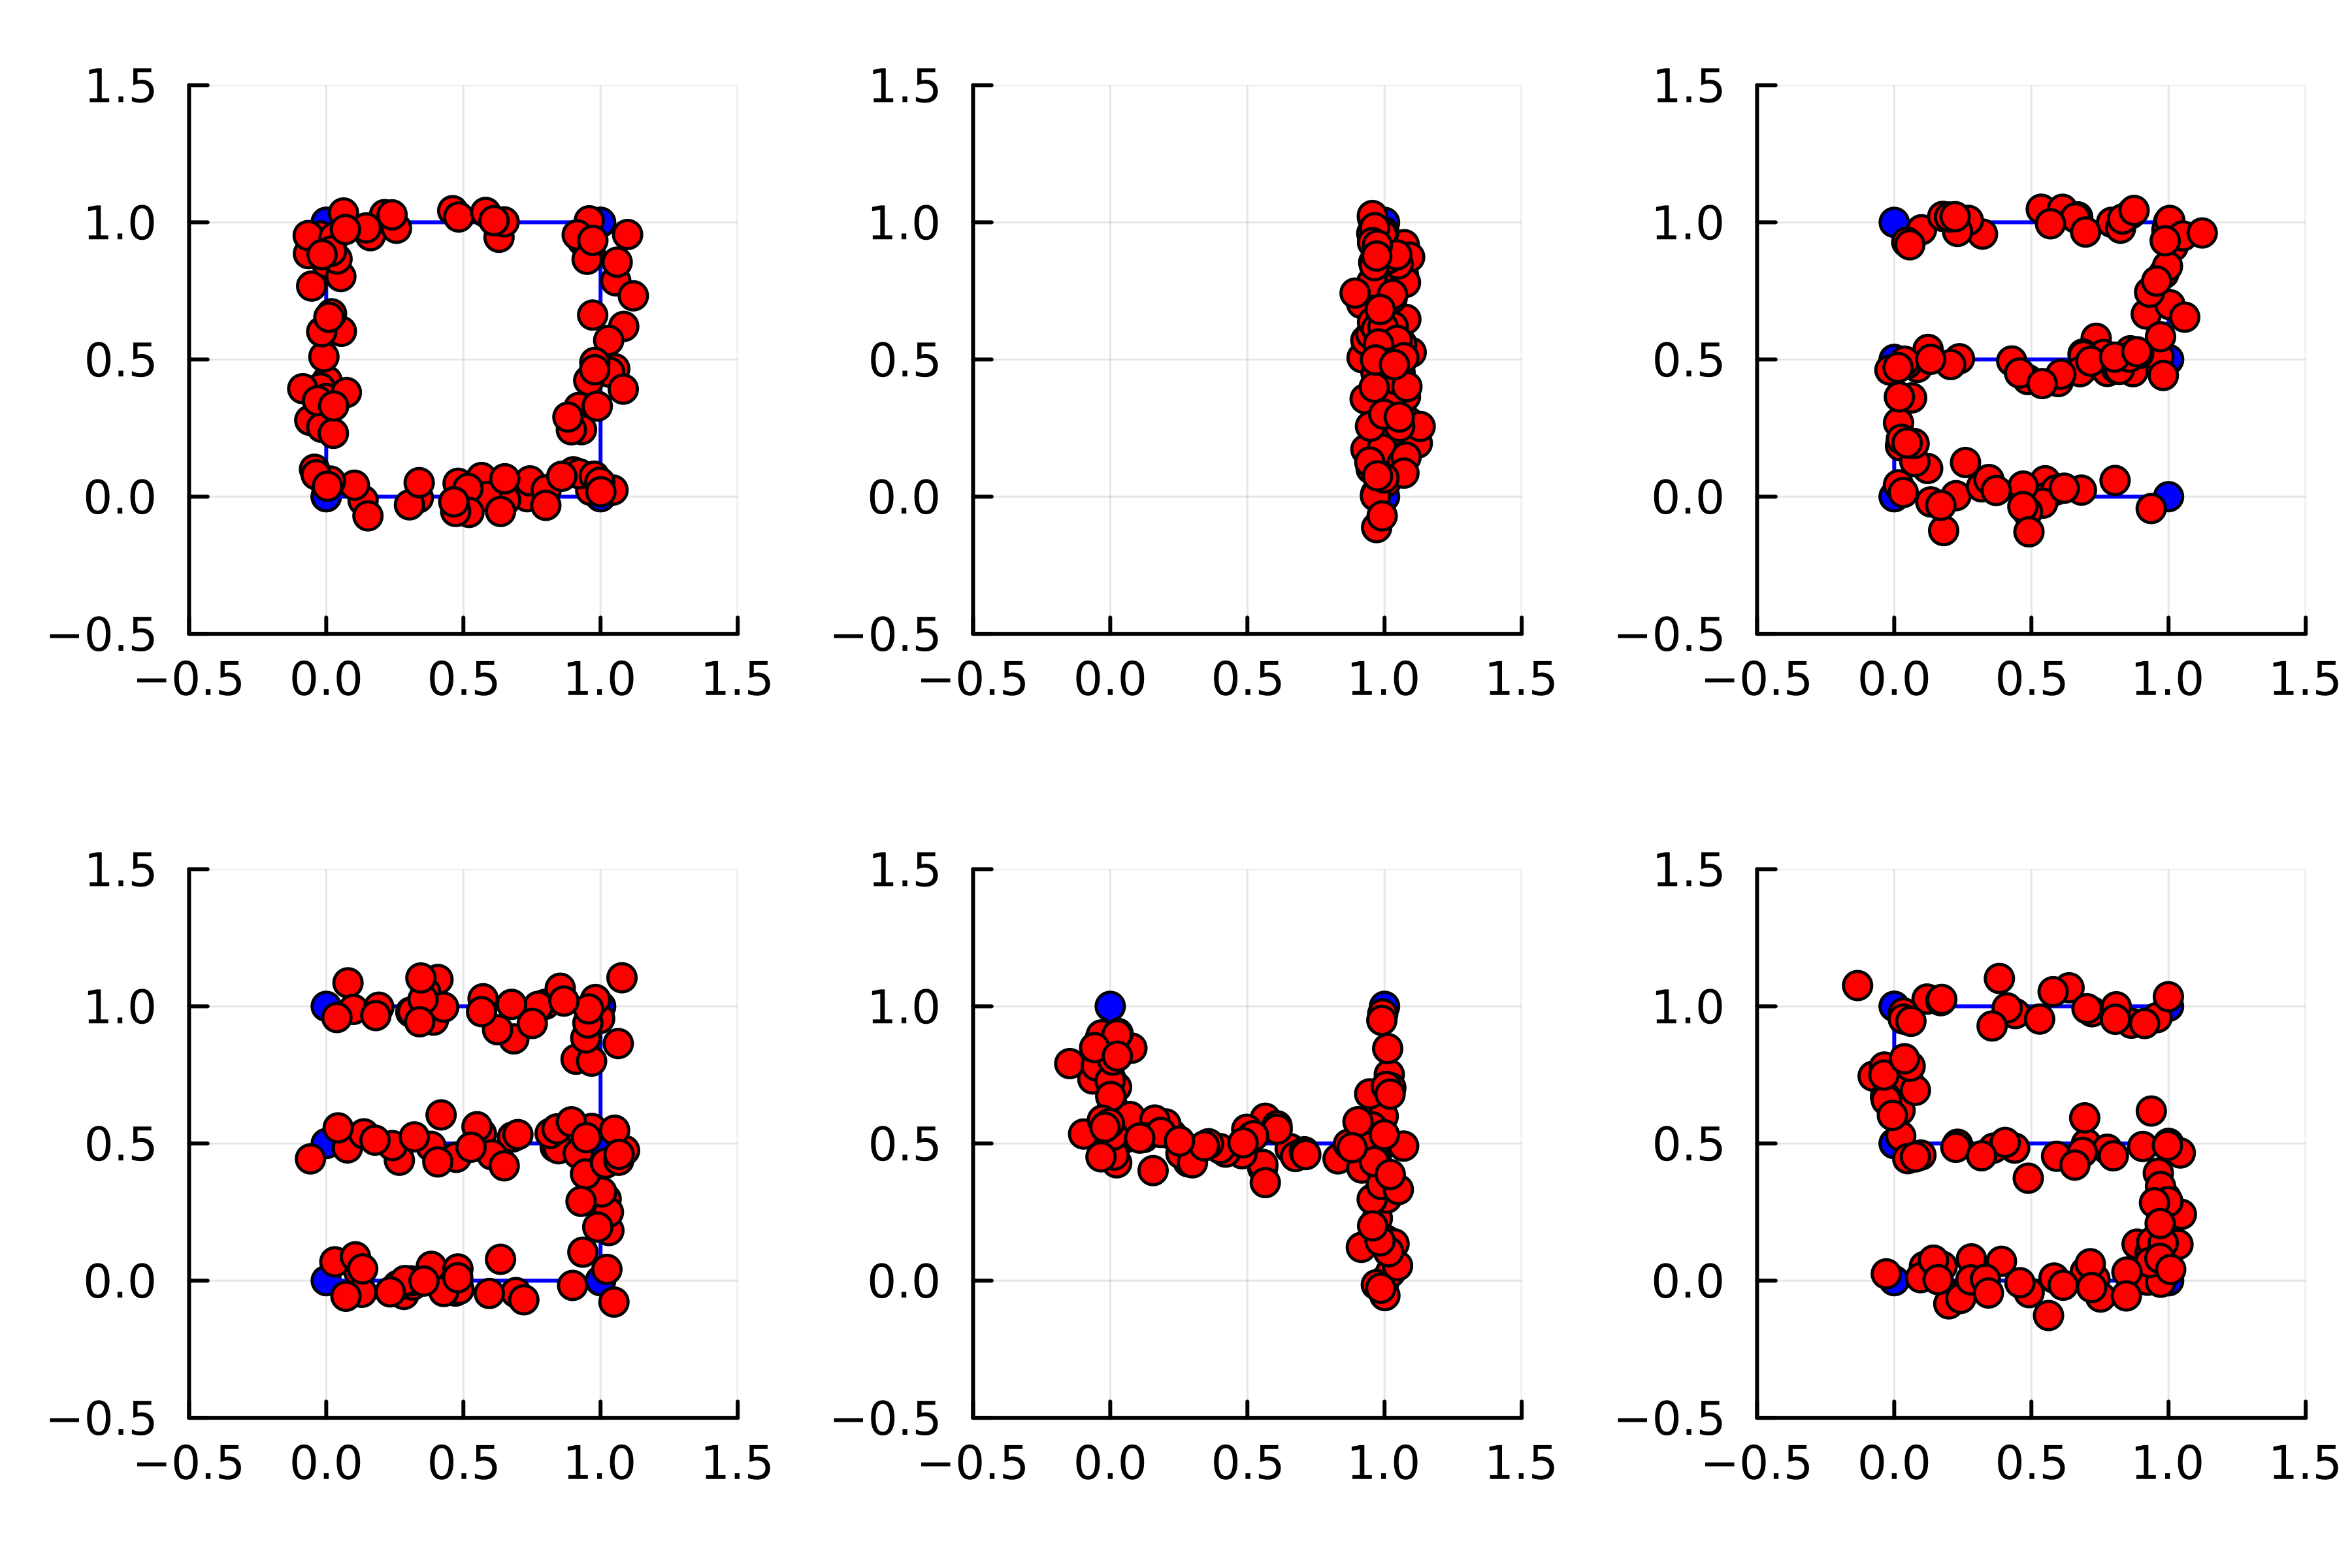

In [4]:
# Plot all digits with lines
plots = []

for number in 0:5
    digit = get_digit(number)
    obs_xs, obs_ys = sample_digit(digit, 100)

    p = Plots.scatter(digit.xs, digit.ys, markercolor="blue", legend=false, xlimits=(-0.5, 1.5), ylimits=(-0.5, 1.5),
    aspect_ratio=:equal)
    for line in 1:size(digit.lengths)[1]
        Plots.plot!([digit.xs[2*line-1], digit.xs[2*line]], [digit.ys[2*line-1], digit.ys[2*line]], color="blue", legend=false)
    end
    # Plots.plot!(digit.xs, digit.ys, color="blue", legend=false)
    Plots.scatter!(obs_xs, obs_ys, markercolor="red", legend=false, aspect_ratio=:equal)
    push!(plots, p)
end
plot(plots..., dpi=600)

### Do inference

Note that, like with the pixel method, this also does not work!

In [5]:
function do_inference(model, obs_xs, obs_ys, amount_of_computation)
    obs = Gen.choicemap()
    for i in 1:size(obs_xs)[1]
        obs[(:p_x, i)] = obs_xs[i]
        obs[(:p_y, i)] = obs_ys[i]
    end
    (trace, lml_est) = Gen.importance_resampling(model, (), obs, amount_of_computation)
    return trace, lml_est
end

do_inference (generic function with 1 method)

Inferred number: 3
ml_est: 0.0


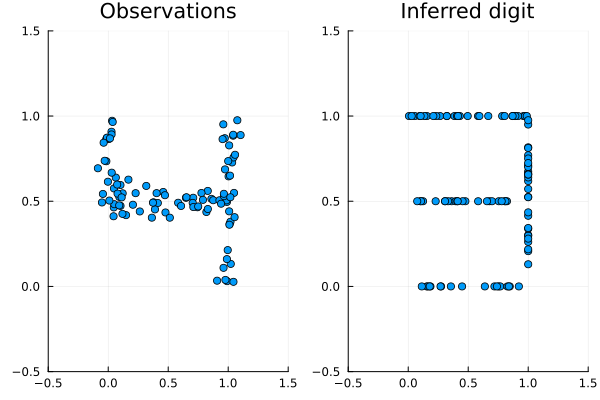

In [6]:
number = 4
constraints = Gen.choicemap()
constraints[(:number)] = number
trace, _ = Gen.generate(number_model, (), constraints)
obs_xs, obs_ys = Gen.get_retval(trace)


inference_trace, lml_est = do_inference(number_model, obs_xs, obs_ys, 10000)


inf_ts = []
for i in 1:size(obs_xs)[1]
    push!(inf_ts, inference_trace[(:t, i)])
end

inf_xs = []
inf_ys = []
inferred_digit = get_digit(inference_trace[(:number)])
# inferred_digit = get_digit(number)  # DEBUG
for i in 1:size(inf_ts)[1]
    push!(inf_xs, sample_digit_t(inferred_digit, inf_ts[i])[1])
    push!(inf_ys, sample_digit_t(inferred_digit, inf_ts[i])[2])
end

println("Inferred number: ", inference_trace[(:number)])
println("ml_est: ", exp(lml_est))

p1 = Plots.scatter(obs_xs, obs_ys, legend=false, xlims=(-0.5,1.5), ylims=(-0.5,1.5), title="Observations")
p2 = Plots.scatter(inf_xs, inf_ys, legend=false, xlims=(-0.5,1.5), ylims=(-0.5,1.5), title="Inferred digit")
Plots.plot(p1, p2, layout=(1,2))